# Diffusion on 3D Point Clouds
This notebook demonstrates how to use diffusion models for generating or denoising 3D point clouds.

## 1. Import Required Libraries
We will use PyTorch, NumPy, and Open3D for point cloud processing and visualization.

In [1]:
# Install Open3D if not already installed
!pip install open3d
!pip install ipywidgets

import torch
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# o3d.visualization.webrtc_server.enable_webrtc()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 2. Load or Generate 3D Point Cloud Data
We will generate a synthetic point cloud (e.g., a sphere) for demonstration.

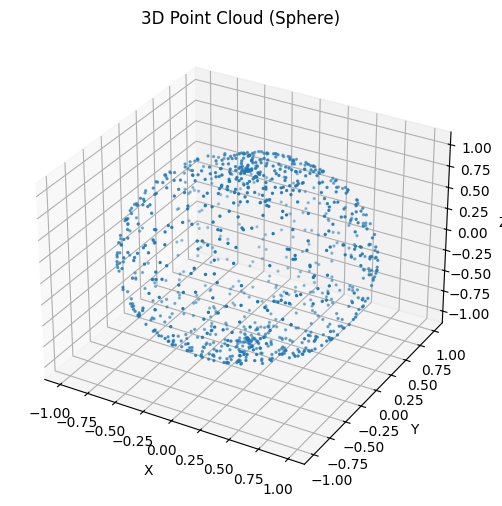

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def sample_sphere(n_points=1024, radius=1.0):
    phi = np.random.uniform(0, np.pi, n_points)
    theta = np.random.uniform(0, 2 * np.pi, n_points)
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    return np.stack([x, y, z], axis=1)

points = sample_sphere()

# Visualize the point cloud using matplotlib
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud (Sphere)')
plt.show()

## 3. Preprocess Point Cloud Data
Normalize the point cloud to zero mean and unit variance.

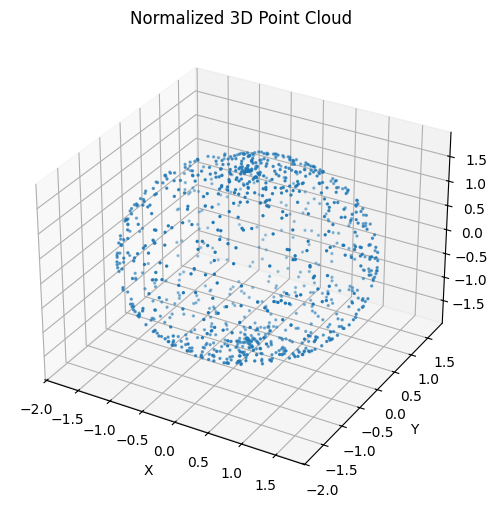

In [6]:
# Normalize the point cloud
def normalize_point_cloud(pc):
    pc = pc - np.mean(pc, axis=0)
    pc = pc / np.std(pc)
    return pc

points_norm = normalize_point_cloud(points)

# Visualize normalized point cloud using matplotlib
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_norm[:, 0], points_norm[:, 1], points_norm[:, 2], s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Normalized 3D Point Cloud')
plt.show()

## 4. Define a Simple 3D Point Cloud Diffusion Model
We will use a basic denoising diffusion probabilistic model (DDPM) for demonstration.

In [7]:
# Simple MLP denoiser for 3D point clouds (for demonstration)
import torch.nn as nn

class PointCloudDenoiser(nn.Module):
    def __init__(self, point_dim=3, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(point_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, point_dim)
        )
    def forward(self, x):
        return self.net(x)

denoiser = PointCloudDenoiser()


## 5. Run Inference with the Diffusion Model
We will simulate a denoising process on the point cloud using the simple denoiser.

In [8]:
# Add Gaussian noise to the normalized point cloud
noise_level = 0.2
noisy_points = points_norm + np.random.normal(scale=noise_level, size=points_norm.shape)

# Denoise using the (untrained) denoiser for demonstration
with torch.no_grad():
    input_tensor = torch.tensor(noisy_points, dtype=torch.float32)
    denoised_points = denoiser(input_tensor).numpy()


## 6. Visualize Original, Noisy, and Denoised Point Clouds
We will use Open3D to visualize the results.

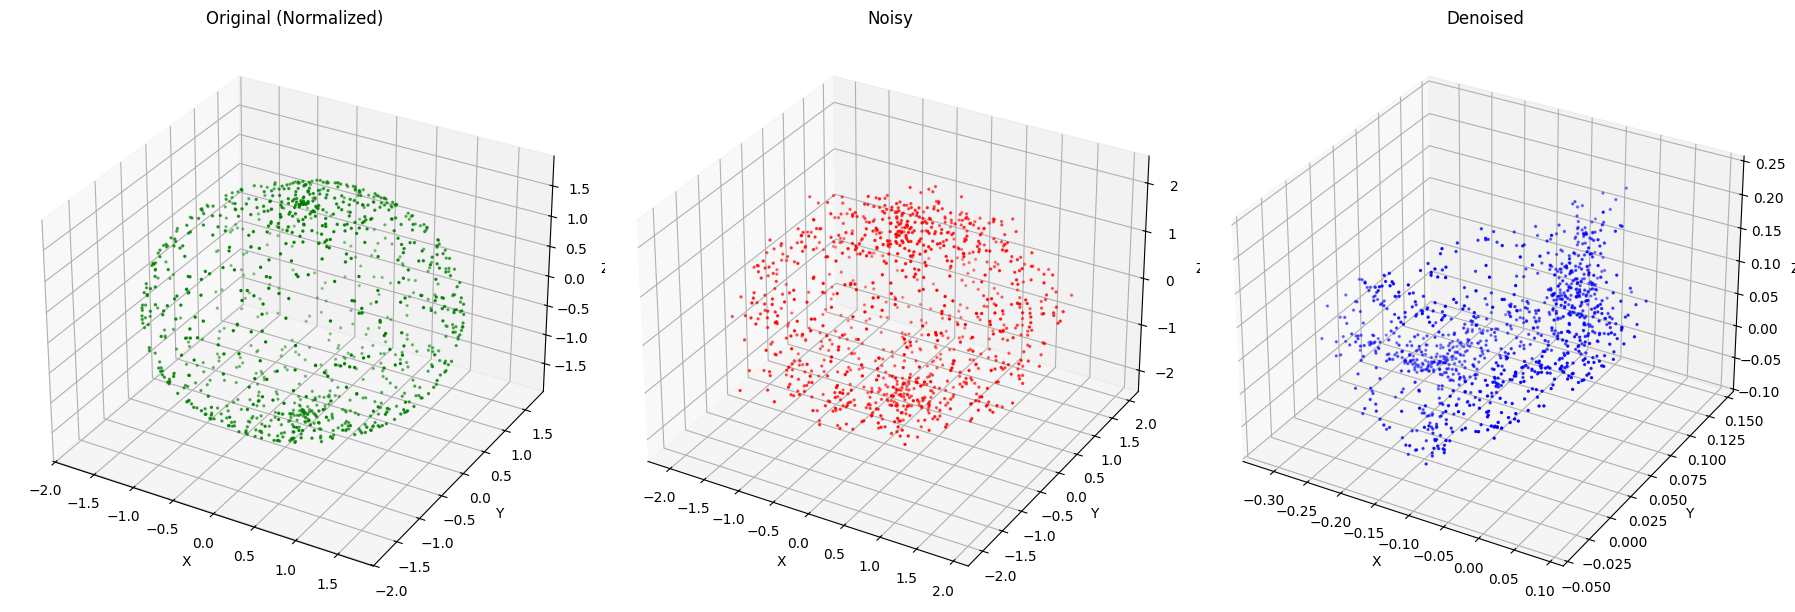

In [10]:
# Visualize all point clouds using matplotlib
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(points_norm[:, 0], points_norm[:, 1], points_norm[:, 2], s=2, c='g')
ax1.set_title('Original (Normalized)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(noisy_points[:, 0], noisy_points[:, 1], noisy_points[:, 2], s=2, c='r')
ax2.set_title('Noisy')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(denoised_points[:, 0], denoised_points[:, 1], denoised_points[:, 2], s=2, c='b')
ax3.set_title('Denoised')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.tight_layout()
plt.show()

## 7. Generate a 3D Point Cloud from a Text Prompt using Point-E
We will use OpenAI's Point-E to generate a 3D point cloud from a text prompt and visualize it with matplotlib.

In [12]:
# Install Point-E if not already installed
!pip install point_e

# Import Point-E and generate a 3D point cloud from a text prompt
from point_e.diffusion.sampler import PointCloudSampler
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Point-E base model and diffusion
base_name = 'base40M'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.load_state_dict(load_checkpoint(base_name, device))
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

# Create sampler
sampler = PointCloudSampler(
    device=device,
    models=[base_model],
    diffusions=[base_diffusion],
    num_points=1024,
    aux_channels=[],
    guidance_scale=3.0,
)

# Generate a point cloud from a text prompt
prompt = "a red apple"
samples = list(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt])))
pc = sampler.output_to_point_clouds(samples[-1])[0]

# Visualize the generated point cloud using matplotlib
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc.coords[:, 0], pc.coords[:, 1], pc.coords[:, 2], s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Point-E: "{prompt}"')
plt.show()

ERROR: Could not find a version that satisfies the requirement point_e (from versions: none)
ERROR: No matching distribution found for point_e


ModuleNotFoundError: No module named 'point_e'